In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json


In [2]:
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

In [3]:
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

In [4]:
d = get_part_data(df_reviews, 40000)
d["is_spoiler"] = d["is_spoiler"].astype('int')

df_r = d[["review_text","is_spoiler"]]

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model

train_text = (df_reviews['review_summary'].map(str) + ' ~~~ ' + df_reviews['review_text'].map(str)).to_numpy()
train_labels = df_reviews["is_spoiler"].to_numpy().astype(np.int32)


In [6]:
# lower the words in training data
#ltexts = [[word.lower() for word in line.split()] for line in train_text]

In [7]:
import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [8]:
def preprocess(text):
    text = ' '.join(text)
    # tokenization and removing stop words
    token = [t for t in nlp(text) if not t.is_stop] 
    # lemmatization
    lemma = [lem.lemma_ for lem in token]
    # removing the non-alphabetic words
    return [' '.join(i for i in lemma if i.isalpha()) ]

In [9]:
# proc_text = []
# for i in range(len(ltexts)):
#     proc_text.append(preprocess(ltexts[i]))

In [10]:
train_labels = np.asarray(train_labels).astype('float32').reshape((-1,1))

In [11]:
reviewMaxLen = 700

tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)
padded = pad_sequences(sequences, maxlen=reviewMaxLen)

In [12]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=reviewMaxLen) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(32, dropout=0.1, return_sequences=True))
model.add(LSTM(32, dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=[tf.keras.metrics.AUC()])

2021-12-28 09:20:30.263678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 09:20:30.264779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 09:20:30.265434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 09:20:30.266230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
history = model.fit(padded, train_labels, validation_split=0.25, epochs=3, batch_size=64, verbose=1)
model.save('model')

2021-12-28 09:20:38.532914: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1205215200 exceeds 10% of free system memory.
2021-12-28 09:20:39.527546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2021-12-28 09:20:43.126460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6725/6726 [============================>.] - ETA: 0s - loss: 0.5253 - auc: 0.7122

2021-12-28 09:26:04.579777: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 401741200 exceeds 10% of free system memory.


6726/6726 [==============================] - 365s 54ms/step - loss: 0.5253 - auc: 0.7122 - val_loss: 0.4511 - val_auc: 0.7857
Epoch 2/3
6726/6726 [==============================] - 357s 53ms/step - loss: 0.4823 - auc: 0.7715 - val_loss: 0.4439 - val_auc: 0.7938
Epoch 3/3
6726/6726 [==============================] - 357s 53ms/step - loss: 0.4717 - auc: 0.7841 - val_loss: 0.4408 - val_auc: 0.7947


2021-12-28 09:39:07.276637: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-28 09:39:12.620128: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49526656 exceeds 10% of free system memory.
2021-12-28 09:39:12.662869: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49526656 exceeds 10% of free system memory.
2021-12-28 09:39:12.701703: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49526656 exceeds 10% of free system memory.


In [14]:
model = load_model('model')

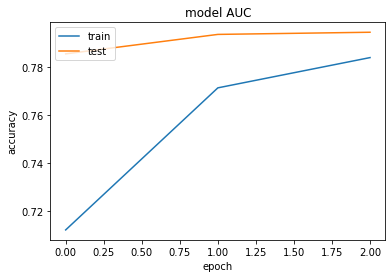

In [15]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title ('model AUC')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()